<a href="https://colab.research.google.com/github/SweetyKekS/Brain-tumor/blob/main/Object_Detection_brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задача: обучить нейронку определять координаты центра опухоли в головном мозге.** 


# Подключим библиотеки, каталог с изображениями и координатами bbox

In [ ]:
import os # библиотека для работы с ОС
import pandas as pd # библиотека для работы с xlsx файлом
import torch # библиотека для создания тензоров, выборок и другое
import copy # для глубокого копирования параметров модели нейронной сети
import torchvision  # библиотека для трансформирования изображений, дял подсчёта области пересечения bounding boxes (Индекс Жаккара)
from torch.optim.lr_scheduler import ReduceLROnPlateau # динамическое изменение learning rate во время обучения при плато на метрике обучения
from torch.utils.data import Dataset # класс для создания набора данных pytorch
import torch.nn as nn # нейронные слои
import torch.nn.functional as F # сверточные функции для нейронной сети
from torch.utils.data import DataLoader # разделение выборки на batch size
from torch import optim # оптимизаторы для нейронной сети
import random # функции для генерации случайных чисел, букв, случайного выбора элементов последовательности.
from sklearn.model_selection import ShuffleSplit # разделения данных на обучающие и тестовые наборы.
import numpy as np # базовые методы для манипуляции с большими массивами и матрицами
from torch.utils.data import Subset # класс, который выбирает данные из общего датасета по указанным индексам
import torchvision.transforms.functional as TF # класс для аугментации данных
from PIL import Image, ImageDraw # классы для отображения и изменения изображений
import matplotlib.pyplot as plt # библиотека для отображения графиков
from torchsummary import summary # вывод архитекруты модели
# график  строится все в той же оболочке Jupyter, но теперь он выводится как обычная картинка
%matplotlib inline 
np.random.seed(42) # установка начального числа для алгоритма генератора псевдослучайных чисел в Python

In [ ]:
from google.colab import drive # метод для подключения google диск

drive.mount('/content/drive') # подключаем google диск
path = '/content/drive/MyDrive/Diplom/brain_tumor/' # указываем путь к папке с изображениями
path2labels = '/content/drive/MyDrive/Diplom/brain_tumor/coordinates.xlsx' # указываем путь к файлу с координатами bounding boxes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels_df = pd.read_excel(path2labels,index_col=0) # загрузим файл с координатами
print(labels_df.head()) # выведем первые 5 строк

   imgName    X    Y
ID                  
1    1.jpg  223  180
2    2.jpg  232  185
3    3.jpg  221  194
4    4.jpg  220  197
5    5.jpg  217  199


# Создадим функции загрузки и показа изображений

In [ ]:
plt.rcParams['figure.figsize'] = (15,9) # устанавливаем разрешение рисунка 15х9 dpi
plt.subplots_adjust(wspace= 0, hspace= 0.3) # настраиваем область subplot'ов, wspace - ширина, зарезервированная для пространства между подграфиками; hspace -высоту, зарезервированную для пространства между подграфиками
nrows, ncols = 2,3 # для изображений создадим 6 подграфиков, 2 строки и 3 колонки

imgName = labels_df['imgName'] # создадим список  всех имен изображений
ids = labels_df.index # список из индексов изображений
rndIds = np.random.choice(ids, nrows*ncols) # рандомно выберем 6 индексов
print(rndIds) # посмотрим какие индексы выбрались

[103 349 271 107  72 189]


<Figure size 1080x648 with 0 Axes>

In [ ]:
def load_img_label(labels_df, id_): # создадим функцию загрузки изображений и координат центра bounding box
    imgName = labels_df['imgName'] # создадим список  всех имен изображений
    fullpath2img = os.path.join(path,'images', imgName[id_]) # указываем путь к изображению с указанным id_
    img = Image.open(fullpath2img) # покажем изобрежение
    x = labels_df['X'][id_] # укажем координату Х центра bounding box 
    y = labels_df['Y'][id_] # укажем координату Y центра bounding box 
    label = (x,y) # объединим координаты в кортеж
    return img, label # функция возвращает изображение и координаты центра bounding box

In [ ]:
def show_img_label(img, label, w_h = (40,40), thickness = 3): # создадим функцию показа изображений с bounding box; w_h - ширину и высоту bounding box; thickness - толщина линии bbox. 
    w,h = w_h # записываем в переменные значения ширины и высоты
    cx,cy = label # записываем в переменные значения координат центра bbox
    draw = ImageDraw.Draw(img) #  рисуем выбранное img
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline= 'white', width= thickness) # и вырисовываем на нём bbox шириной и высотой 40х40, цвет линии - белый, толщина линии - 3 dpi
    plt.imshow(np.asarray(img), cmap= 'gray') # покажем изображение в черно-белом цвете, так как МРТ делается в ЧБ


(192, 256) (81, 200)
(512, 512) (313, 309)
(192, 256) (124, 154)
(256, 256) (95, 146)
(256, 256) (85, 172)
(192, 256) (54, 211)


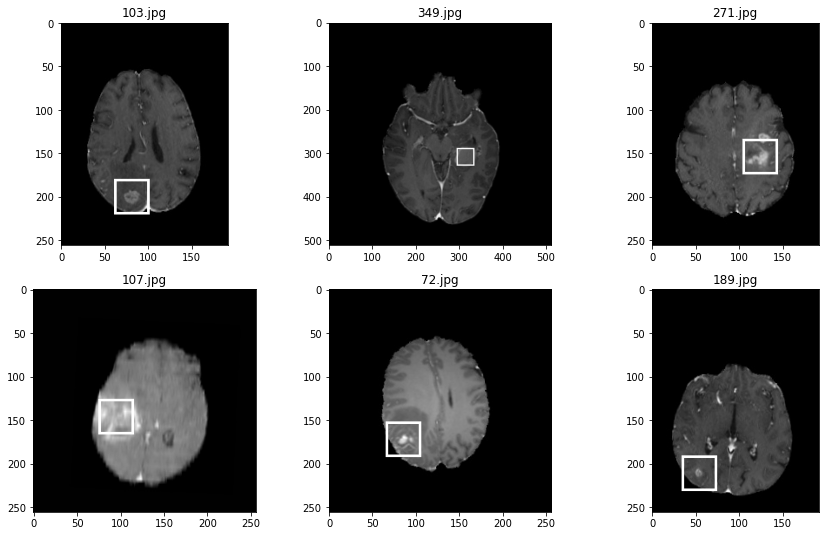

In [ ]:
for i, id_ in enumerate(rndIds): # создадим цикля для 6 изображений
    img, label = load_img_label(labels_df, id_) # создадим переменные для изображения и координат центра bbox
    print(img.size, label) # выведем размер изображения и координаты центра bbox
    plt.subplot(nrows, ncols, i+1) # создадим подграфики 2х3 и укажем очередность показа изображений
    show_img_label(img, label, w_h = (40,40), thickness=3) # выведем изображение и указанными аргументами
    plt.title(imgName[id_]) # подпишем каждое изображение
plt.show() # выведем все подграфики

# Выведем гистограммы по статистике разрешения изображений

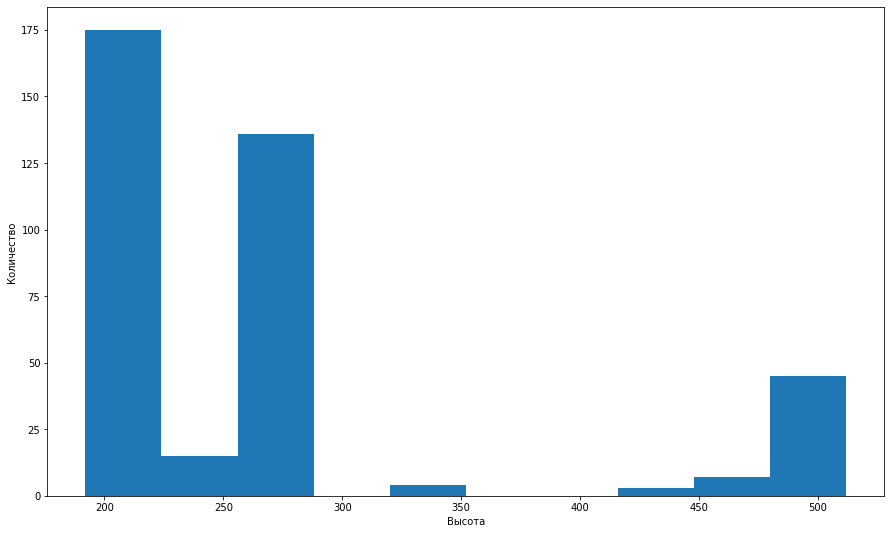

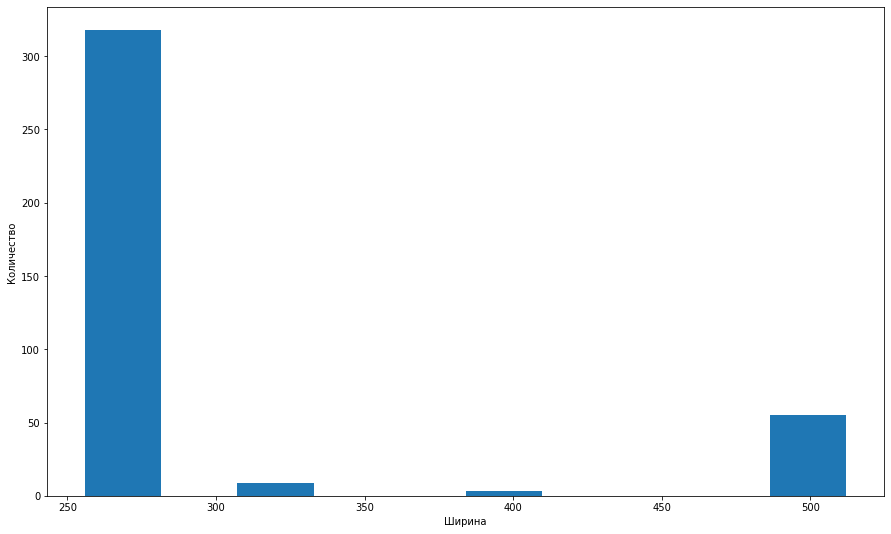

In [ ]:
h_list, w_list = [], [] # создадим списки для подсчета количества изображений по высоте и ширине
for id_ in ids: # создадим цикл 
    fullpath2img = os.path.join(path,'images', imgName[id_]) # укажем путь к изображению
    img = Image.open(fullpath2img) # загрузим в переменную изображение
    h,w = img.size # сохраним высоту и ширину
    h_list.append(h) # добавим высоту в список
    w_list.append(w) # добавим ширину в список
    

plt.hist(x= h_list) # нарисуем гистограмму высоты изображений
plt.xlabel('Высота') # по х оси высота
plt.ylabel('Количество') # по у оси количество изображений
plt.show() # выведем гистрограмму
plt.hist(x= w_list) # нарисуем гистограмму ширины изображений
plt.xlabel('Ширина') # по х оси ширина
plt.ylabel('Количество') # по у оси количество изображений
plt.show() # выведем гистрограмму


# Создадим функции для аугментации изображений

In [ ]:
def random_shift(image, label, max_traslate = (0.2, 0.2)): # функция аффиного преобразования изображения влево, вправо, вверх или вниз
                                                            
                                                           # 256*256 максимальное перемещение будет 51 пиксель в каждом направлении
    w,h = image.size # ширина, высота
    cx,cy = label # центр bbox
    max_t_w, max_t_h = max_traslate # максимальныt коэффициенты сдвига в размерах x и y будет 0,2*ширина и 0,2*высота
                                    # например, для размера изображения 256*256 максимальное перемещение будет 51 пиксель в каждом направлении 
    trans_coef = np.random.rand()*2-1 # коэффициент преобразования
    w_t = int(trans_coef*max_t_w*w) # новое значение ширины
    h_t = int(trans_coef*max_t_h*h) # новое значение высоты
    image = TF.affine(image, translate=(w_t, h_t), shear=0, angle=0, scale=1) # аффиного преобразования изображения, translate - горизонтальные и вертикальные сдвиги (перевод после вращения),
                                                                              # shear -значение угла сдвига в градусах от -180 до 180 по часовой стрелке. 
                                                                              # eсли указана последовательность, первое значение соответствует сдвигу, параллельному оси x, а второе значение соответствует сдвигу, параллельному оси y
                                                                              # scale - изменения масштаба
    label = cx+w_t, cy+h_t # новые координаты bbox
    return image, label # возвращаем изображение и координаты bbox

(512, 512) (223, 180)
(256, 256) (111.5, 90.0)


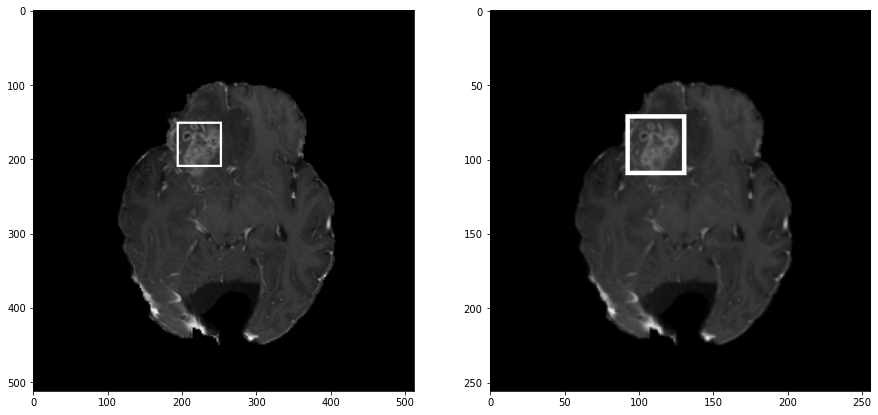

In [ ]:
def resize_img_label(image, label = (0.,0.), target_size= (256,256)): # создадим функцию изменения разрешения изображений, в аргументы принимается изображение, кортеж из координат центра bbox, конечное разрешение изображений
    w_orig, h_orig = image.size # запишем в переменные оригинальные разрешения изображений
    w_target, h_target = target_size # запишем в переменные конечные разрешения изображений
    cx, cy = label # координаты центра bbox
    image_new = TF.resize(image, target_size) # с помощью метода functional делаем resize изображения
    label_new = cx/w_orig*w_target, cy/h_orig * h_target # создаем координаты центра bbox для нового разрешения изображения
    return  image_new, label_new # возвращаем измененное изображение и координаты центра bbox

img, label = load_img_label(labels_df, 1) # загрухим первое изображение
print(img.size, label) # выведем размер и координаты bbox

img_r, label_r = resize_img_label(img, label) # изменим первое изображение
print(img_r.size, label_r) # выведем новые размер и координаты bbox

plt.subplot(1,2,1) # создадим подграфик
show_img_label(img, label, w_h = (60,60), thickness=3) # покажем изображение

plt.subplot(1,2,2) # создадим подграфик
show_img_label(img_r, label_r) # покажем изображение
plt.show() # выведем все изображения

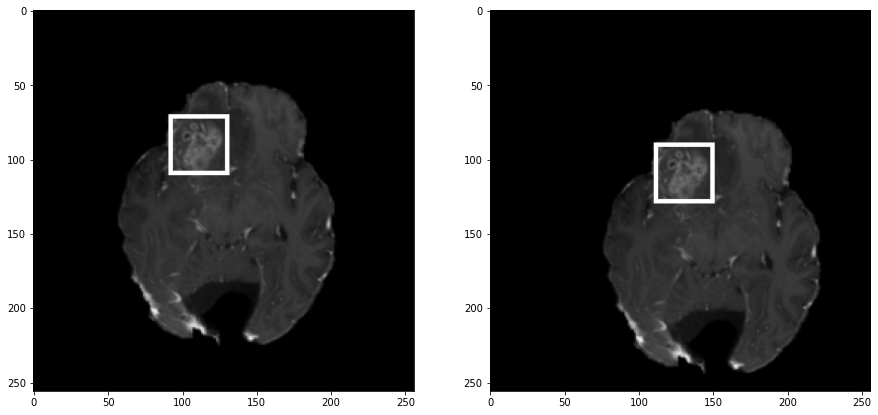

In [ ]:
img, label = load_img_label(labels_df,1) # загрухим первое изображение
img_r, label_r = resize_img_label(img, label) # изменим первое изображение
img_t, label_t = random_shift(img_r, label_r, max_traslate=(0.4, 0.4)) # сдвигаем изображение

plt.subplot(1,2,1) # создадим подграфик
show_img_label(img_r, label_r) # покажем изображение

plt.subplot(1,2,2) # создадим подграфик
show_img_label(img_t, label_t) # покажем изображение
plt.show() # выведем все изображения

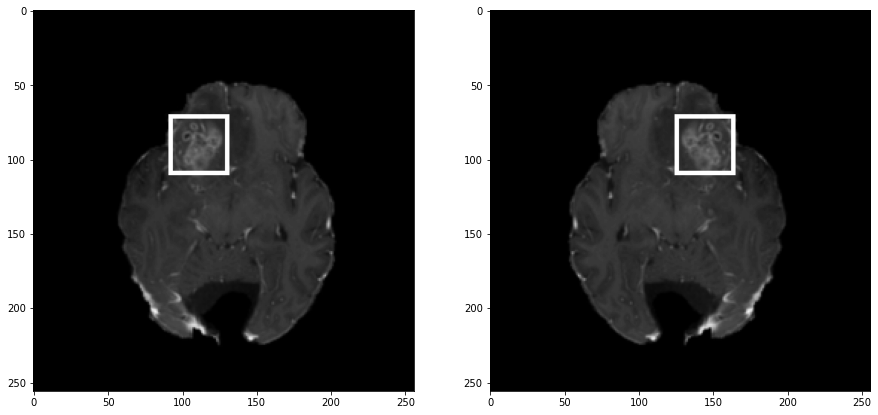

In [ ]:
def random_hflip(image, label): # создадим функцию отражения заданного изображения по горизонтали
    w,h = image.size # ширина, высота изображения
    x,y = label # координаты центра bbox

    image = TF.hflip(image) # горизонтальное изменение изображения
    label = w-x, y # изменим координаты по оси х
    return image, label # возвратим новое изображение и координаты

img, label = load_img_label(labels_df,1) # загрузим изображение с координатами
img_r, label_r = resize_img_label(img, label) # изменим разрешение изображения и координат
img_hf, label_hf = random_hflip(img_r, label_r) # перевернем изображение

plt.subplot(1,2,1) # создадим подграфик
show_img_label(img_r, label_r) # выведем изображение после resize

plt.subplot(1,2,2) # создадим подграфик
show_img_label(img_hf, label_hf) # выведем изображение после переворота
plt.show() # покажем все изображения


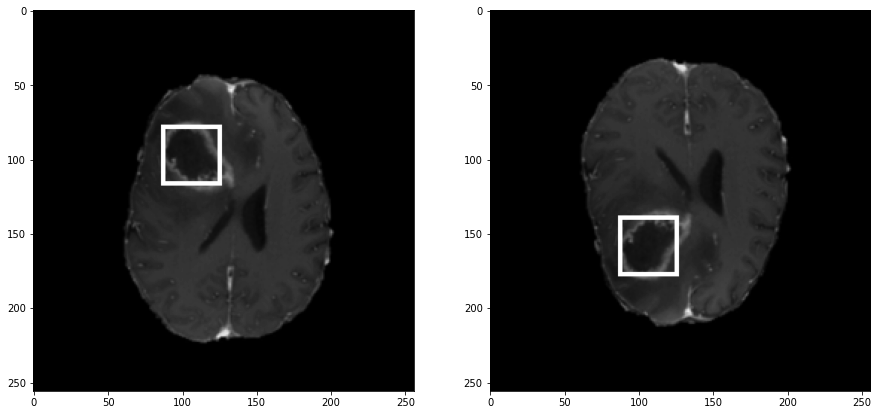

In [ ]:
def random_vflip(image, label): # создадим функцию отражения заданного изображения по вертикали
    w,h = image.size # ширина, высота изображения
    x,y = label # координаты центра bbox

    image = TF.vflip(image) # вертикальное изменение изображения
    label = x, h - y # изменим координаты по оси у
    return image, label # возвратим новое изображение и координаты

img, label = load_img_label(labels_df,7) # загрузим изображение с координатами
img_r, label_r = resize_img_label(img, label) # изменим разрешение изображения и координат
img_vf, label_vf = random_vflip(img_r, label_r) # перевернем изображение

plt.subplot(1,2,1) # создадим подграфик
show_img_label(img_r, label_r) # выведем изображение после resize

plt.subplot(1,2,2) # создадим подграфик
show_img_label(img_vf, label_vf) # выведем изображение после переворота
plt.show() # покажем все изображения


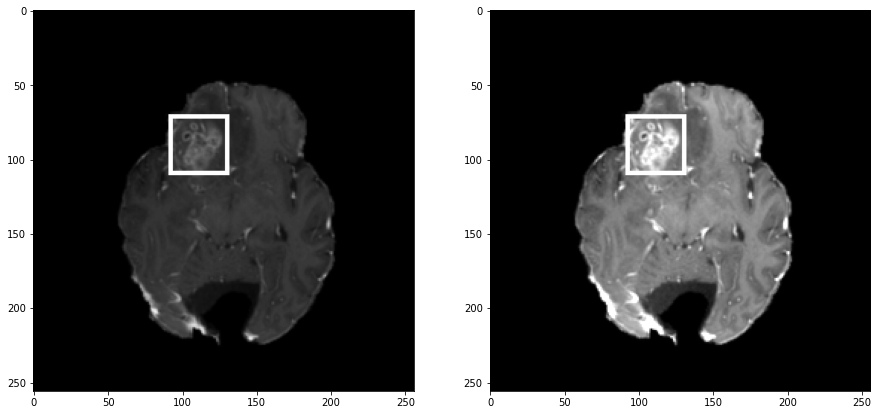

In [ ]:
img, label = load_img_label(labels_df, 1) # загрузим изображение с координатами
img_r, label_r = resize_img_label(img, label) # изменим разрешение изображения и координат

img_t = TF.adjust_brightness(img_r, brightness_factor= 2.5) # изменим яркость изображение, brightness_factor -  0 дает черное изображение, 1 дает исходное изображение, а 2 увеличивает яркость в 2 раза
label_t = label_r # координаты центра bbox

plt.subplot(1,2,1) # создадим подграфик
show_img_label(img_r, label_r) # выведем изображение после resize

plt.subplot(1,2,2) # создадим подграфик
show_img_label(img_t, label_t, ) # выведем изображение после изменения яркости
plt.show() # показать все изображения


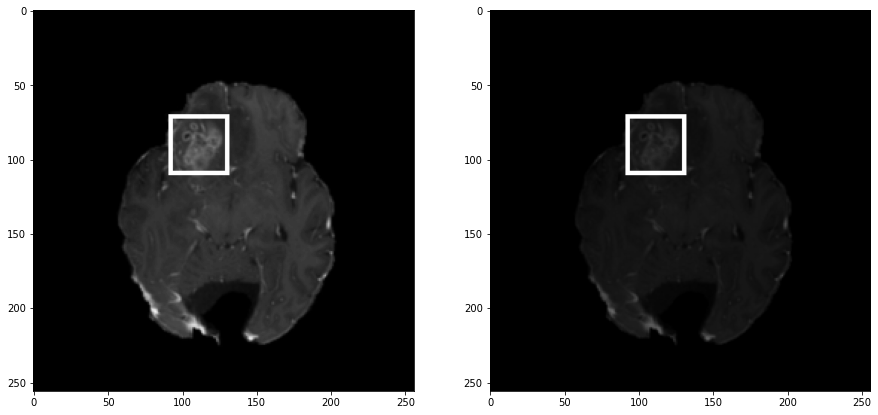

In [ ]:
img, label = load_img_label(labels_df, 1) # загрузим изображение с координатами
img_r, label_r = resize_img_label(img, label) # изменим разрешение изображения и координат

img_t = TF.adjust_contrast(img_r, contrast_factor= 0.4) # изменим контрастность изображения, contrast_factor -  0 дает серое изображение, 1 дает исходное изображение, а 2 увеличивает контрастность в 2 раза
label_t = label_r # координаты центра bbox

plt.subplot(1,2,1) # создадим подграфик
show_img_label(img_r, label_r) # выведем изображение после resize

plt.subplot(1,2,2) # создадим подграфик
show_img_label(img_t, label_t, ) # выведем изображение после изменения яркости
plt.show() # показать все изображения

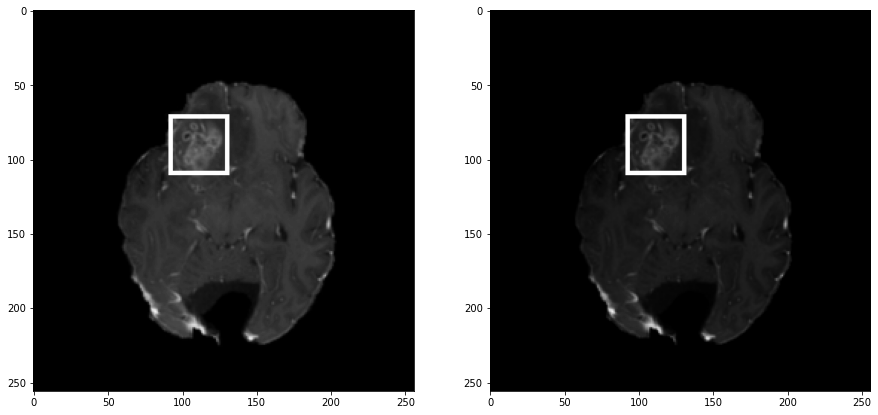

In [ ]:
img, label = load_img_label(labels_df, 1) # загрузим изображение с координатами
img_r, label_r = resize_img_label(img, label) # изменим разрешение изображения и координат

img_t = TF.adjust_gamma(img_r, gamma= 1.4) # выполним гамма-коррекцию изображения, gamma -   больше 1 делает тени темнее, а  меньше 1 делает темные области светлее
label_t = label_r # координаты центра bbox

plt.subplot(1,2,1) # создадим подграфик
show_img_label(img_r, label_r) # выведем изображение после resize

plt.subplot(1,2,2) # создадим подграфик
show_img_label(img_t, label_t, ) # выведем изображение после изменения яркости
plt.show() # показать все изображения

In [ ]:
def scale_label(a,b): # функция изменения масштаба bbox, аргументы принимают два кортежа, а - координаты центра bbox, b - новое разрешение изображения
    div = [ai/bi for ai,bi in zip(a,b)] # делим значение координаты оси х на новое разрешение по оси х, и значение координаты оси у на новое разрешение по оси у
    return  div # возвращаем новое значение координат центра bbox

def rescale_label(a,b): # функция возвращения первоначального масштаба bbox, аргументы принимают два кортежа, а - координаты центра bbox, b - новое разрешение изображения
    div = [ai*bi for ai,bi in zip(a,b)] # умножаем значение координаты оси х на  разрешение по оси х, и значение координаты оси у на  разрешение по оси у
    return  div # возвращаем  значение координат центра bbox

def transformer(image, label, params): # функция трансформирования изображения для аугментации
    image, label = resize_img_label(image, label, params['target_size']) # получаем изображение и координаты центра bbox
    if random.random() < params['p_hflip']: # проверяем условие, если True, то проводим трасформацию изображения 
        image, label = random_hflip(image, label) # проводим горизонтальное отражение
    if random.random() < params['p_vflip']: # проверяем условие, если True, то проводим трасформацию изображения
        image, label = random_vflip(image, label) # проводим вертикальное отражение
    if random.random() < params['p_shift']: # проверяем условие, если True, то проводим сдвиг изображения
        image, label = random_shift(image, label,params['max_translate']) # проводим сдвиг отражение
    if random.random() < params['p_brightness']: # проверяем условие, если True, то проводим трасформацию изображения
        brightness_factor = 1 + (np.random.rand()*2 -1) * params['brightness_factor'] # указываем коэффициент изменения яркости
        image = TF.adjust_brightness(image, brightness_factor) # применяем коэффициент изменения яркости к изображению 
    if random.random() < params['p_contrast']: # проверяем условие, если True, то проводим трасформацию изображения
        contrast_factor = 1 + (np.random.rand()*2 -1) * params['contrast_factor'] # указываем коэффициент контрастности изображения
        image = TF.adjust_contrast(image, contrast_factor) # применяем коэффициент изменения контрастности к изображению 
    if random.random() < params['p_gamma']: # проверяем условие, если True, то проводим трасформацию изображения
        gamma = 1 + (np.random.rand()*2 -1) * params['gamma'] # указываем коэффициент гаммы изображения
        image = TF.adjust_brightness(image, gamma) # применяем коэффициент изменения гаммы к изображению 
    if params['scale_label']: # проверяем условие, если True, то проводим трасформацию изображения
        label = scale_label(label, params['target_size']) # применяем изменения масштаба bbox
    image = TF.to_tensor(image) # конвертируем изображение в тензор

    return  image, label # возвращаем изображение и bbox

# Проверим работу аугментации изображений

In [ ]:
img, label = load_img_label(labels_df, 1) # загрузим изображение и координаты bbox

# создадим словарь с параметрами трасформации изображения 
params = {
    'target_size': (256,256), # конечное разрешение изображения
    'p_hflip': 1.0, # вероятность горизонтального отображения
    'p_vflip': 1.0, # вероятность вертикального отображения
    'p_shift': 1.0, # вероятность сдвига отображения
    'max_translate': (0.4, 0.4), # максимальныt коэффициенты сдвига в размерах x и y
    'p_brightness': 1.0, # вероятность изменения яркости изображения
    'brightness_factor': 0.8, # коэффициент изменения яркости
    'p_contrast': 1.0, # вероятность изменения контрастности изображения
    'contrast_factor': 0.8, # коэффициент изменения контрастности
    'p_gamma': 1.0, # вероятность изменения гамма-коррекции изображения
    'gamma': 0.4, # коэффициент изменения гамма-коррекции изображения
    'scale_label': False # изменения масштаба bbox
}


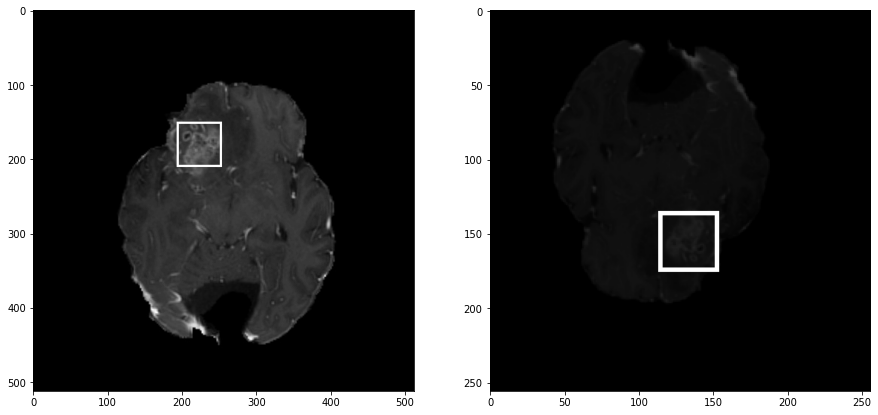

In [ ]:
img, label = load_img_label(labels_df, 1) # загрузим изображение с координатами
img_t, label_t = transformer(img, label, params) # применим функцию трасформации к первому изображению

plt.subplot(1,2,1) # создадим подграфик
show_img_label(img, label, w_h = (60,60), thickness=3) # выведем изображение 

plt.subplot(1,2,2) # создадим подграфик
show_img_label(TF.to_pil_image(img_t), label_t, thickness=3) # выведем изображение после трансформации
plt.show() # показать все изображения



# Создадим класс для загрузки всех необходимых данных для обучения нейронки

In [ ]:
class brain(Dataset): # создадим класс для возвращения изображения, координат центра bbox
    def __init__(self, path, transform, trans_params): # инициализация эксземпляра класса, path - путь к файлам, transform - функция трасформации, trans_params - параметры трансформации
        path2labels = os.path.join(path,'coordinates.xlsx') # путь к файлу с координатами bbox
        labels_df = pd.read_excel(path2labels, index_col='ID') # индексы изображений
        self.labels = labels_df[['X', 'Y']].values # значения координат центров bbox
        self.imgName = labels_df['imgName'] # имя файла
        self.ids = labels_df.index # индексы координат bbox
        self.fullPath2img = [0] * len(self.ids) # создадим список, количество объектов равно количеству изображений
        for id_ in self.ids:  # создадим цикл          
          self.fullPath2img[id_ - 1] = os.path.join(path,'images', self.imgName[id_]) # каждый объект списка изменим на путь к изображению
        self.transform = transform # функция трансформации
        self.trans_params = trans_params # параметры трансформации
    def __len__(self): # метод вывода количества изображений
        return len(self.labels) # возвращаем количество изображений
    def __getitem__(self, idx): # метод вывода изображения и его координат bbox по индексу
        image = Image.open(self.fullPath2img[idx]) # откроем изображение
        label = self.labels[idx] # сохраним координаты центра bbox
        image, label = self.transform(image, label, self.trans_params) # сделаем трансформацию изображения
        return image, label # возвращаем изображение и координаты центра bbox
        

# Создадим словари параметров для аугментации изображений тренировочной и проверочной выборках

In [ ]:
trans_params_train = {
    'target_size': (256,256), # конечное разрешение изображения
    'p_hflip': 0.5, # вероятность горизонтального отображения
    'p_vflip': 0.5, # вероятность вертикального отображения
    'p_shift': 0.5, # вероятность сдвига отображения
    'max_translate': (0.2, 0.2), # максимальныt коэффициенты сдвига в размерах x и y
    'p_brightness': 0.5, # вероятность изменения яркости изображения
    'brightness_factor': 0.2, # коэффициент изменения яркости
    'p_contrast': 0.5, # вероятность изменения контрастности изображения
    'contrast_factor': 0.2, # коэффициент изменения контрастности
    'p_gamma': 0.5, # вероятность изменения гамма-коррекции изображения
    'gamma': 0.2, # коэффициент изменения гамма-коррекции изображения
    'scale_label': True, # изменения масштаба bbox
}

In [ ]:
trans_params_val = {
    'target_size': (256,256), # конечное разрешение изображения
    'p_hflip': 0.0, # вероятность горизонтального отображения
    'p_vflip': 0.0, # вероятность вертикального отображения
    'p_shift': 0.0, # вероятность сдвига отображения
    'p_brightness': 0.0, # вероятность изменения яркости изображения
    'p_contrast': 0.0, # вероятность изменения контрастности изображения
    'p_gamma': 0.0, # вероятность изменения гамма-коррекции изображения
    'gamma': 0.0, # коэффициент изменения гамма-коррекции изображения
    'scale_label': True, # изменения масштаба bbox
}

# Создадим датасеты

In [ ]:
ds1 = brain(path,transformer, trans_params_train) # создадим экземплям класса  для обучающих данных
ds2 = brain(path,transformer, trans_params_val) # создадим экземплям класса  для проверочных данных
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # перемешивает  со случайной перестановкой, дает индексы для разделения данных на обучающие и тестовые наборы; раздедение 80% на 20%
indices = range(len(ds1)) # количество изображений

In [ ]:
for train_index, val_index in sss.split(indices): # покажем количество изображений в тренировочном и проверочном выборках
    print(len(train_index)) # количество изображений в тренировочной выборке
    print('-'*10) # разделим значения чертой
    print(len(val_index)) # количество изображений в проверочной выборке
    pass

308
----------
77


In [ ]:
train_ds = Subset(ds1, train_index) # в тренировочную выборку мы добавим 308 изображений с трансформацией 
print(len(train_ds)) # выведем

val_ds = Subset(ds2, val_index) # в проверочную выборку мы добавим 77 изображений без трансформации
print(len(val_ds)) # выведем

308
77


In [ ]:
def show(img, label=None): # создадим функцию преобразования изображения в numpy массив и транспонируем его для отображения
    npimg =img.numpy().transpose((1,2,0)) # переводм в массив и транспонируем
    npimg = npimg[:, :, 0] # изменим 3 ось нашего массива для отображения черно-белого изображения
    plt.imshow(npimg, cmap = 'gray') # покажем изображение в черно-белом цвете
    if label is not None: # если необходимо показать bbox
        label = rescale_label(label, img.shape[1:]) # возвращаем первоночальные координаты bbox
        x,y = label # сохраняем координаты х и у
        plt.plot(x,y, 'r+', markersize = 20) # нарисуем на изображении МРТ в центре координат bbox красный крест, размер - 20 dpi
        plt.show() # выведем изображение

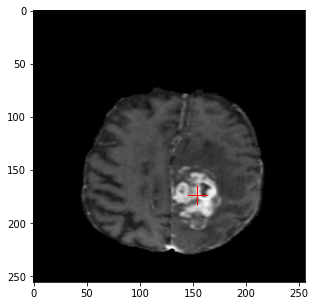

torch.Size([1, 256, 256])


In [ ]:
plt.figure(figsize=(5,5))  # укажем размер графика
for img,label in train_ds: # цикл для отображение изображения и центра bbox в тренировочной выборке
    show(img, label) # функция возвращает изображение и центра bbox
    print(img.shape) # выведем размерность изображения
    break # остановим цикл

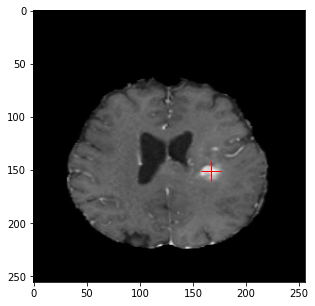

In [ ]:
plt.figure(figsize=(5,5)) # укажем размер графика
for img,label in val_ds: # цикл для отображение изображения и центра bbox в проверочной выборке
    show(img, label) # функция возвращает изображение и центра bbox
    break # остановим цикл


In [ ]:
train_dl = DataLoader(train_ds,batch_size= 8, shuffle= True) # перемешаем изображения и создадим batch'и для обучения нейронки
val_dl = DataLoader(val_ds,batch_size=16, shuffle=False) # перемешаем изображения и создадим batch'и для проверки нейронки

In [ ]:
for img_b, label_b in train_dl: #  цикл для получения изображения и координат bbox в тренировочной выборке
    print(img_b.shape, img_b.dtype) # выведем размерность batch и его тип
    label_b = torch.stack(label_b,1) # stack - сшивает в один список значения по 1 оси указаных списков
    label_b = label_b.type(torch.float32) # переводим тип списка в float32
    print(label_b) # выведем список
    print(label_b.shape, label_b.dtype) # выведем размерность батча и тип
    break # остановим цикл

torch.Size([8, 1, 256, 256]) torch.float32
tensor([[0.5573, 0.3281],
        [0.6979, 0.7227],
        [0.5033, 0.2949],
        [0.4805, 0.4648],
        [0.6055, 0.4023],
        [0.2240, 0.3750],
        [0.4414, 0.0625],
        [0.5469, 0.6523]])
torch.Size([8, 2]) torch.float32


In [ ]:
for img_b, label_b in val_dl: #  цикл для получения изображения и координат bbox в тренировочной выборке
    print(img_b.shape, img_b.dtype) # выведем размерность batch и его тип
    label_b = torch.stack(label_b,1) # stack - сшивает в один список значения по 1 оси указаных списков
    label_b = label_b.type(torch.float32) # переводим тип списка в float32
    print(label_b) # выведем список
    print(label_b.shape, label_b.dtype) # выведем размерность батча и тип
    break # остановим цикл

torch.Size([16, 1, 256, 256]) torch.float32
tensor([[0.6510, 0.5898],
        [0.3542, 0.5000],
        [0.6484, 0.5352],
        [0.6758, 0.5547],
        [0.6875, 0.4766],
        [0.3984, 0.6602],
        [0.6719, 0.4648],
        [0.8021, 0.6367],
        [0.4062, 0.6719],
        [0.4180, 0.4238],
        [0.3490, 0.4844],
        [0.6875, 0.5938],
        [0.4174, 0.7891],
        [0.3542, 0.6562],
        [0.4141, 0.5898],
        [0.4453, 0.3594]])
torch.Size([16, 2]) torch.float32


# Создадим класс для нашей нейронки

In [ ]:
class Net(nn.Module): # создадим класс нашей нейронки
    def __init__(self, params): # инициализация экземпляра класса
        super(Net,self).__init__() # инициализируем супер класс для наследования базовых методов
        C_in, H_in, W_in = params['input_shape'] # сохраним размерность массива
        init_f = params['initial_filters'] # из словаря сохраним количество нейронов
        num_outputs = params['num_outputs'] # выходные нейроны(центр bbox)
        # self.dropout = nn.Dropout(0.5)
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1) # сверточный слой, ядром 3х3, шагом - 2, padding - количество слоев, чтобы добавить 0 к каждой стороне ввода
        self.conv2 = nn.Conv2d(init_f + C_in, 2*init_f, kernel_size=3, stride=1, padding=1) # сверточный слой с увеличенным количеством нейронов
        self.conv3 = nn.Conv2d(3*init_f + C_in, 4*init_f, kernel_size=3,  padding=1) # сверточный слой с увеличенным количеством нейронов
        self.conv4 = nn.Conv2d(7*init_f + C_in, 8*init_f, kernel_size=3,  padding=1) # сверточный слой с увеличенным количеством нейронов
        self.conv5 = nn.Conv2d(15*init_f + C_in, 16*init_f, kernel_size=3,  padding=1) # сверточный слой с увеличенным количеством нейронов
        self.fc1 = nn.Linear(16*init_f, num_outputs) # линейный слой, выравниваем массив в вектор

    def forward (self, x): # метод прохода обучающей выборки по нейронной сети
        identity= F.avg_pool2d(x,4) # ядро 4х4 с усредненным значением 
        x = F.relu(self.conv1(x)) # линейная функция активации
        # x = self.dropout(x) # слой dropout
        x = F.max_pool2d(x,2) # ядро 2х2 с максимальным значением без уменьшения размерности 
        x = torch.cat((x, identity), dim = 1) # объединяет два тензора по первой оси

        identity = F.avg_pool2d(x, 2) # ядро 2х2 с усредненным значением
        x = F.relu(self.conv2(x)) # линейная функция активации
        x = F.max_pool2d(x, 2) # ядро 2х2 с максимальным значением 
        x = torch.cat((x, identity), dim=1) # объединяет два тензора по первой оси

        identity = F.avg_pool2d(x, 2) # ядро 2х2 с усредненным значением 
        x = F.relu(self.conv3(x)) # линейная функция активации
        x = F.max_pool2d(x, 2) # ядро 2х2 с максимальным значением 
        x = torch.cat((x, identity), dim=1) # объединяет два тензора по первой оси

        identity = F.avg_pool2d(x, 2) # ядро 2х2 с усредненным значением  
        x = F.relu(self.conv4(x)) # линейная функция активации
        x = F.max_pool2d(x, 2) # ядро 2х2 с максимальным значением 
        x = torch.cat((x, identity), dim=1) # объединяет два тензора по первой оси

        x = F.relu(self.conv5(x)) # линейная функция активации
        x = F.adaptive_max_pool2d(x,1) # Выходной размер адаптивного_max_pool2d для любого входного размера будет таким, какой вы укажете в его аргументе
        x = x.reshape(x.size(0), -1) # решейп в думерный массив

        x = self.fc1(x) # линейный слой, выравниваем массив в вектор

        return x # возвращаем вектор

In [ ]:
params_model = { 
    'input_shape': (1,256,256), # входной размер тензора
    'initial_filters': 16, # начальное количество нейронов
    'num_outputs': 2 # конечное количество нейронов
    }

In [ ]:
model = Net(params_model) # создадим экземпляр нейронки

if torch.cuda.is_available(): # услвоие проверки работы gpu
    device = torch.device('cuda') # если True, то переводим  вычисления на gpu
    model = model.to(device) # переводим нейронку на gpu
else: # если False
    device = torch.device('cpu') #  переводим  вычисления на cpu
    model = model.to(device) # переводим нейронку на cpu

In [ ]:
summary(model, (1, 256, 256)) # выведем архитерктуру модели НС с вычисляемыми параметрами

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
            Conv2d-2           [-1, 32, 64, 64]           4,928
            Conv2d-3           [-1, 64, 32, 32]          28,288
            Conv2d-4          [-1, 128, 16, 16]         130,304
            Conv2d-5            [-1, 256, 8, 8]         555,520
            Linear-6                    [-1, 2]             514
Total params: 719,714
Trainable params: 719,714
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 3.88
Params size (MB): 2.75
Estimated Total Size (MB): 6.87
----------------------------------------------------------------


In [ ]:
print(model) # выведем слои нейронки
print(device) # выведем устройство обработки вычислений

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(17, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(49, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(113, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(241, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)
cuda


# Укажем функцию ошибки, оптимизатор, функцию динамического изменения learning rate

In [ ]:
loss_func = nn.SmoothL1Loss(reduction = 'sum') # функция ошибки. beta=1.0. Считает среднюю абсолютную ошибку (MAE), если ошибка меньше 1, то считает  среднеквадратическую ошибку (MSE). Выходные данные суммирует

In [ ]:
opt = optim.Adam(model.parameters(), lr = 3e-4) # оптимизатор ADAM, learning_rate - 0.0003

In [ ]:
def get_lr(opt): # функция отображения learning_rate
    for param_group in opt.param_groups: # для параметров оптимизатора
        return param_group['lr'] # возвращаем learning_rate

current_lr = get_lr(opt) # сохраним lr
print('current lr = {}'.format(current_lr)) # выведем lr

current lr = 0.0003


In [ ]:
lr_scheduler = ReduceLROnPlateau(opt, mode= 'min', factor= 0.5, patience=20, verbose = 1) # настройка скорости обучения, mode - rогда оптимизированный индекс не уменьшается, изменим скорость обучения, factor -
                                                                                          # new_lr = lr * factor, patience - после скольких эпох плато менять lr, verbose - вывести результат

# Создадим функции для обучения нейронки

In [ ]:
def cxcy2bbox (cxcy, w=50./256, h = 50./256): # функция отрисовки bbox
    w_tensor = torch.ones(cxcy.shape[0],1,device=cxcy.device) * w # создадим двумерный тензор с единицами и умножим на значения ширины
    h_tensor = torch.ones(cxcy.shape[0],1,device=cxcy.device) * h # создадим двумерный тензор с единицами и умножим на значения высоты
    cx = cxcy[:, 0].unsqueeze(1) # возвращает новый тензор с указанной размерностью 
    cy = cxcy[:, 1].unsqueeze(1) # возвращает новый тензор с указанной размерностью 
    boxes = torch.cat((cx,cy,w_tensor, h_tensor), -1) # объединяет тензоры по указанной оси
    return torch.cat((boxes[:,:2] - boxes[:, 2:]  / 2, boxes[:, :2] + boxes[:, 2:] / 2), 1) # возвращаем bbox

In [ ]:
def metrics_batch(output, target): # функция подсчета ошибки (индекса Жаккарда), отношение площади перекрытия боксов к общей площади.
    output = cxcy2bbox(output) # предсказанный bbox
    target = cxcy2bbox(target) # истинный bbox
    iou = torchvision.ops.box_iou(output, target) # определим тензор перекрытия bbox с помощью метода box_iou
    return torch.diagonal(iou, 0).sum().item() # возвращаем суммированное значение главной диагонали тензора перекрытия

In [ ]:
def loss_batch(loss_func, output, target, opt = None): # функция подсчета ошибки всего batch
    loss = loss_func(output, target) # подсчитываем ошибку SmoothL1Loss
    with torch.no_grad(): # отключаем подсчет градиента
        metric_b = metrics_batch(output, target) # считаем точность ( индекс Жаккарда)
    if opt is not None: # если оптимизатор True
        opt.zero_grad() # обнуляем градиент оптимизатора
        loss.backward() # считаем производную
        opt.step() # делаем шаг вперд
    return loss.item(), metric_b # возвращаем значение ошибки и точности

In [ ]:
for xb, label_b in train_dl: # цикл подсчета ошибки и точности
    label_b = torch.stack(label_b, 1) # координаты центра bbox объединим по первой оси
    label_b = label_b.type(torch.float32) # переведем в тив float32
    label_b = label_b.to(device) # переведем для подсчета на gpu или cpu

    l,m = loss_batch(loss_func, label_b, label_b) # подсчет ошибки и точности
    print(l,m) # выведем
    break # остановим цикл

0.0 8.0


In [ ]:
def loss_epoch(model, loss_func, dataset_dl, check = False, opt = None): # функция подсчета ошибки для эпохи
    running_loss = 0.0 # первоначальное значение ошибки
    running_metric = 0.0 # первоначальное значение точности
    len_data = len(dataset_dl.dataset) # количество батчей
    for xb, yb in dataset_dl: # цикл подсчета ошибки и точности
        yb = torch.stack(yb, 1) # объединим координаты bbox по 1 оси
        yb = yb.type(torch.float32).to(device) # переведем в тип float32 и на gpu или cpu
        output = model(xb.to(device)) # предскажем значение bbox
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt) # вычислим ошибку и точность
        running_loss += loss_b # суммируем ошибки
        if metric_b is not None: # если нужно подсчитать точность
            running_metric+= metric_b # суммируем точность
        if check is True: # проверка одного цикла
            break # остановим цикл
    loss = running_loss/float(len_data) # вычислим среднюю ошибку
    metric = running_metric/float(len_data) # вычислим среднюю точность
    return loss, metric # возвратим ошибку и точность

In [ ]:
def train_val(model, params): # функция обучения и проверки нейронки
    np.random.seed(42)
    num_epochs = params['num_epochs'] # количество эпох
    loss_func = params['loss_func'] # функция ошибки
    opt = params['optimizer'] # оптимизатор
    train_dl = params['train_dl'] # батчи тренировочной выборки
    val_dl = params['val_dl'] # батчи проверочной выборки
    check = params['check'] # одна эпоха для проверки, если надо
    lr_scheduler = params['lr_scheduler'] # динамическое изменение learning rate
    path2weights = params['path2weights'] # путь к изображениям
    loss_history = {
        'train': [], # список истории ошибок тренировочной выборки
        'val': [], # список истории ошибок проверочной выборки
    }
    metric_history = {
        'train': [], # список истории точности тренировочной выборки
        'val': [], # список истории точности проверочной выборки
    }
    best_model_wts = copy.deepcopy(model.state_dict()) # делаем глубокую копию лучших значений весов
    best_loss = float('inf') # начальное значение ошибки бесконечноть
    for epoch in range(num_epochs): # цикл эпох
        current_lr = get_lr(opt) # начальный learning rate
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr)) # выведем эпохи и learning rate
        model.train() # начнем обучение нейронки
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, check, opt) # сохраним значения ошибки и точности
        loss_history['train'].append(train_loss) # сохраним ошибку на тренировочной выборке
        metric_history['train'].append(train_metric) # сохраним точность на тренировочной выборке

        model.eval() # проверка модели
        with torch.no_grad(): # без подсчета градиента
            val_loss, val_metric=loss_epoch(model, loss_func, val_dl, check) # сохраним значения ошибки и точности
            loss_history['val'].append(val_loss) # сохраним ошибку на проверочной выборке
            metric_history['val'].append(val_metric) # сохраним точность на проверочной выборке
            if val_loss < best_loss: # проверка на меньшую ошибку
                best_loss = val_loss # сохраняем если True
                best_model_wts = copy.deepcopy(model.state_dict()) #  сохраняем веса нейронки
                torch.save(model.state_dict(), path2weights) # сохраним веса в каталоге
                print('Copied best model weights!') # выведем сообщение
            lr_scheduler.step(val_loss) # шаг изменения learning rate, если необходимо
            if current_lr != get_lr(opt): # если изменение lr произошло
                print('Loading best model weights!') # выведем сообщение
                model.load_state_dict(best_model_wts) # загрузим лучшие веса
            print('train loss: %.6f, accuracy: %.2f' % (train_loss, 100*train_metric)) # выведем ошибку и точность тренировочной выборки 
            print('val_loss: %.6f, accuracy: %.2f' % (val_loss, 100*val_metric)) # выведем ошибку и точность првоерочной выборки 
            print('-'*10) # разделим эпохи

    model.load_state_dict(best_model_wts) # загрузим лучшие веса
    return model, loss_history, metric_history # возвращаем нейронку,  списки ошибок и точности

In [ ]:
loss_func = nn.SmoothL1Loss(reduction= 'sum') # функция ошибки
opt = optim.Adam(model.parameters(), lr = 1e-4) # оптимизатор Adam, lr - 0.0001
lr_scheduler = ReduceLROnPlateau(opt, mode= 'min', factor=0.5, patience=20, verbose = 1) # настройка скорости обучения, mode - rогда оптимизированный индекс не уменьшается, изменим скорость обучения, factor -
                                                                                         # new_lr = lr * factor, patience - после скольких эпох плато менять lr, verbose - вывести результат

In [ ]:
path2models = os.path.join(path,'models') # создадим путь к каталогу для сохранения весов
if not os.path.exists(path2models): # если не существует
    os.mkdir(path2models) # создадим каталог

In [ ]:
print(path2models) # выведем путь 

/content/drive/MyDrive/Diplom/brain_tumor/models


# Обучим нейронку

In [ ]:
# создадим словарь парметров для нейронки

params_train = {
    'num_epochs': 500, # количество эпох
    'optimizer': opt, # оптимизатор
    'loss_func': loss_func, # функция ошибки
    'train_dl': train_dl, # батчи тренировочной выборки
    'val_dl': val_dl, # батчи проверочной выборки
    'check': False, # проверять не нужно
    'lr_scheduler': lr_scheduler, # функция динамического изменения learning rate
    'path2weights': path2models+'/weights_smoothl1.pt' # путь для сохранения весов

}

In [ ]:
print(path2models+'/weights_smoothl1.pt') # файл сохранения весов

/content/drive/MyDrive/Diplom/brain_tumor/models/weights_smoothl1.pt


Epoch 0/499, current lr=0.0001
Copied best model weights!
train loss: 0.058494, accuracy: 6.98
val_loss: 0.022744, accuracy: 12.56
----------
Epoch 1/499, current lr=0.0001
Copied best model weights!
train loss: 0.029429, accuracy: 10.47
val_loss: 0.019786, accuracy: 10.61
----------
Epoch 2/499, current lr=0.0001
Copied best model weights!
train loss: 0.023740, accuracy: 10.91
val_loss: 0.017961, accuracy: 10.49
----------
Epoch 3/499, current lr=0.0001
Copied best model weights!
train loss: 0.021329, accuracy: 10.65
val_loss: 0.017508, accuracy: 11.45
----------
Epoch 4/499, current lr=0.0001
Copied best model weights!
train loss: 0.021153, accuracy: 12.01
val_loss: 0.014621, accuracy: 15.85
----------
Epoch 5/499, current lr=0.0001
Copied best model weights!
train loss: 0.016099, accuracy: 14.20
val_loss: 0.013452, accuracy: 16.37
----------
Epoch 6/499, current lr=0.0001
Copied best model weights!
train loss: 0.013921, accuracy: 18.51
val_loss: 0.012287, accuracy: 20.35
----------


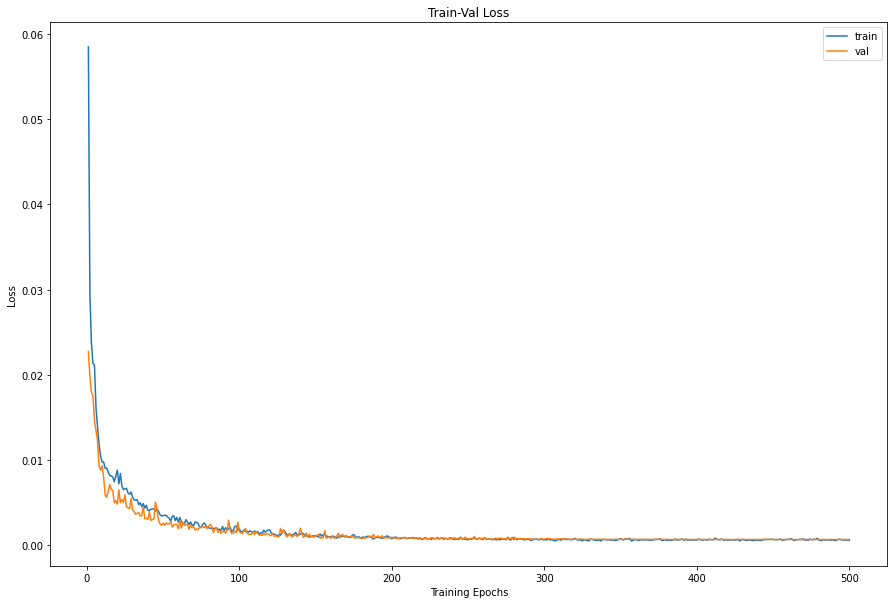

In [ ]:
model,loss_hist, metric_hist = train_val(model, params_train) # обучаем и проверяем нейронку и сохраняем ошибку и точность

num_epochs = params_train['num_epochs'] # сохраним значение количества эпох
plt.title('Train-Val Loss') # подпишем график ошибки
plt.plot(range(1,num_epochs+1), loss_hist['train'], label = 'train') # график ошибки тренировочной выборки
plt.plot(range(1,num_epochs+1), loss_hist['val'], label = 'val') # график ошибки проверочной выборки
plt.ylabel('Loss') # по оси у - значение ошибки
plt.xlabel('Training Epochs') # по оси х -  эпоха
plt.legend() # выведем все подписи
plt.show() # выведем график

## Проверим лучшие значения ошибки и точности

In [ ]:
path2weights = params_train['path2weights'] # путь к лучшим весам

model.load_state_dict(torch.load(path2weights)) # загрузим веса

with torch.no_grad(): # без подсчета градиента
    loss,metric = loss_epoch(model, loss_func,val_dl) # подсчет ошибки и точности с загруженными весами
print('Ошибка: ',round(loss,6),'\nТочность: ', round(metric*100,1), '%') # выведем значения ошибки и точности

Ошибка:  0.000663 
Точность:  72.5 %


## Нарисуем графики точности тренировочной и проверочной выборок

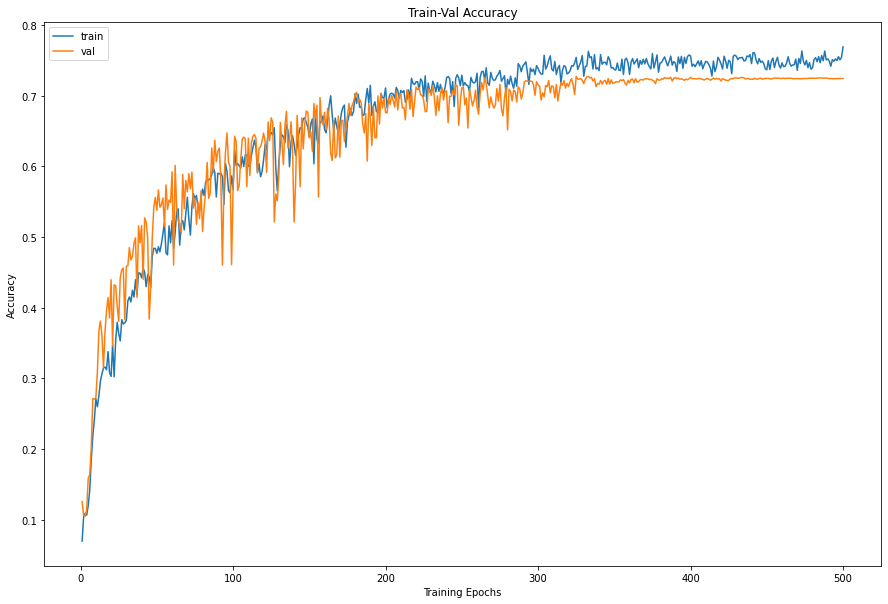

In [ ]:
num_epochs = params_train['num_epochs']

plt.title('Train-Val Accuracy') # подпишем график точности
plt.plot(range(1,num_epochs+1), metric_hist['train'], label = 'train') # график точности тренировочной выборки
plt.plot(range(1,num_epochs+1), metric_hist['val'], label = 'val') # график точности проверочной выборки
plt.ylabel('Accuracy') # ось у - точность
plt.xlabel('Training Epochs') # ось х - эпоха
plt.legend() # выведем надписи
plt.show() # выведем график


# Проверим работу нейронки

In [ ]:
def show_tensor_2labels(img, label1, label2, w_h = (50,50)): # функция вывода изображения с предсказанном и истинном bbox, label1 - истинные значения координат bbox, label2 - предсказанные значения координат bbox
    label1 = rescale_label(label1,img.shape[1:]) # сохраним истинные значения координат bbox 
    label2 = rescale_label(label2,img.shape[1:]) # сохраним предсказанные значения координат bbox 
    img = TF.to_pil_image(img) # преобразуем тензор  в изображение PIL
    w,h = w_h # сохраним ширину и высоту bbox
    cx,cy = label1 # истинные координаты bbox 
    draw = ImageDraw.Draw(img) # выведем изображение 
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline = 'gray', width=2) # нарисуем на изображении истинный bbox серым цветом
    cx,cy = label2 # предсказанные координаты bbox
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline = 'white', width=2) #  нарисуем на изображении предсказанный bbox белым цветом
    plt.imshow(np.asarray(img), cmap = 'gray') # выведем черно-белое изображение


[51 14 71 60 20 74 74 23  2 21]


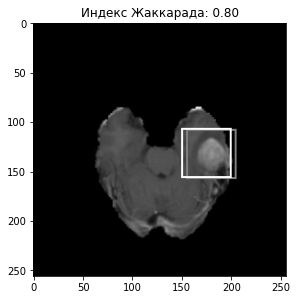

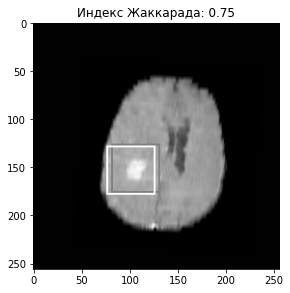

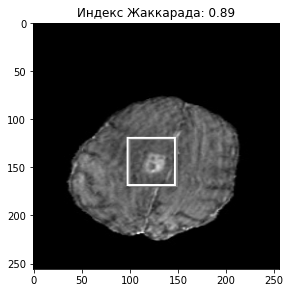

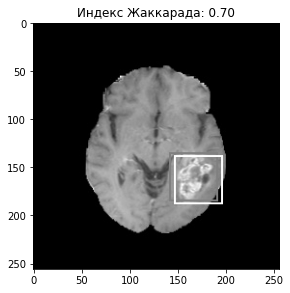

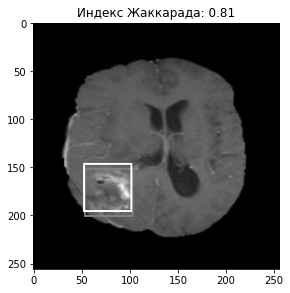

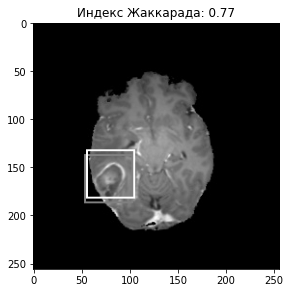

In [ ]:
np.random.seed(42)
rndInds = np.random.randint(len(val_ds), size=10) # рандомно выберем 10 чисел из проверочной выборки
print(rndInds) # выведем список

plt.rcParams['figure.figsize'] = (15,10) # укажем размеры полотна для графика
plt.subplots_adjust(wspace = 0.0, hspace = 0.15) # укажем отступы между подграфиками

for i, rndi in enumerate(rndInds): # пройдемся по выбраным рандомно изображениям и присвоим индексы
    img,label = val_ds[rndi] # сохраним изображение и координаты bbox
    h,w = img.shape[1:] # высота и ширина изображения
    with torch.no_grad(): # предскажем координаты bbox без счета градиента
        label_pred = model(img.unsqueeze(0).to(device))[0].cpu() # предсказываем координаты bbox, unsqueeze - добавляет размерность по указанной оси, переводим на cpu 
    plt.subplot(2,3,i+1) # рисуем полотно для подграфиков 2 строки на 3 столбца
    show_tensor_2labels(img,label,label_pred) # рисуем истинный и предсказанный bbox
    # считаем индекс Жаккарда (IOU)
    label_bb = cxcy2bbox(torch.tensor(label).unsqueeze(0)) # переводим истинный bbox в тензор и добавляем 0 ось
    label_pred_bb = cxcy2bbox(label_pred.unsqueeze(0)) # переводим предсказанный bbox в тензор и добавляем 0 ось
    iou = torchvision.ops.box_iou(label_bb,label_pred_bb) # считаем индекс Жаккарда
    plt.title('Индекс Жаккарада: %.2f' %iou.item()) # выведем коэффициент пересечения
    plt.show() # выведем изображение
    if i > 4: # если вывели 6 изображений
        break # прерываем цикл

In [ ]:
path2labels = os.path.join(path,'coordinates.xlsx') # путь к файлу с координатами
labels_df = pd.read_excel(path2labels, index_col='ID') # сохраним значения координат bbox

img, label = load_img_label(labels_df, 3) # загрузим первое изображение
print(img.size, label) # выведем размер и координаты bbox
img, label = resize_img_label(img, label, target_size=(256,256)) # изменим размер изображения
print(img.size, label) # выведем размер и координаты bbox

img= TF.to_tensor(img) # переведем изображение в тензор
label = scale_label(label, (256,256)) # изменим масштаб bbox
print(img.shape) # выведем форму

(512, 512) (221, 194)
(256, 256) (110.5, 97.0)
torch.Size([1, 256, 256])


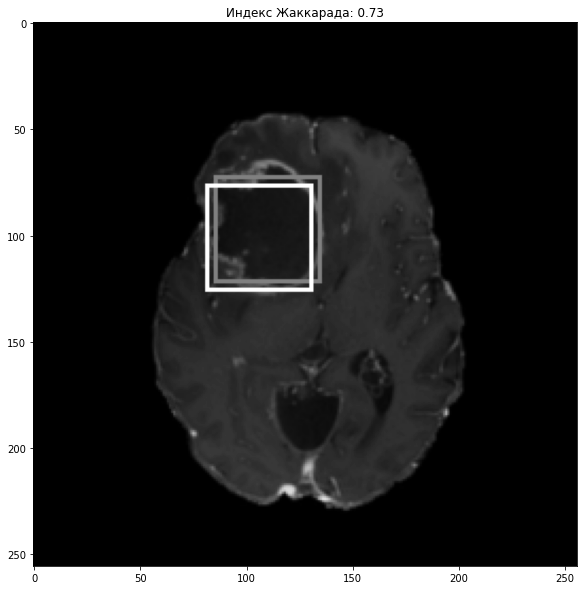

In [ ]:
with torch.no_grad(): # без подсчета градиента
    label_pred = model(img.unsqueeze(0).to(device))[0].cpu() # предсказываем координаты bbox
show_tensor_2labels(img,label, label_pred) # рисуем истинный и предсказанный bbox
label_bb = cxcy2bbox(torch.tensor(label).unsqueeze(0)) # переводим истинный bbox в тензор и добавляем 0 ось
label_pred_bb = cxcy2bbox(label_pred.unsqueeze(0)) # переводим предсказанный bbox в тензор и добавляем 0 ось
iou = torchvision.ops.box_iou(label_bb,label_pred_bb) # считаем индекс Жаккарда
plt.title('Индекс Жаккарада: %.2f' % iou.item()) # выведем коэффициент пересечения
plt.show() # выведем изображение

# Проверка нейронки на тестовом изображении МРТ

In [ ]:
def load_img_label_test(labels_df, id_): # создадим функцию загрузки изображений и координат центра bounding box
    imgName = labels_df['imgName'] # создадим список  всех имен изображений
    fullpath2img = os.path.join(path,'test', imgName[id_]) # указываем путь к изображению с указанным id_
    img = Image.open(fullpath2img) # покажем изобрежение
    x = labels_df['X'][id_] # укажем координату Х центра bounding box 
    y = labels_df['Y'][id_] # укажем координату Y центра bounding box 
    label = (x,y) # объединим координаты в кортеж
    return img, label # функция возвращает изображение и координаты центра bounding box

(512, 512) (190, 225)
(256, 256) (95.0, 112.5)
torch.Size([1, 256, 256])


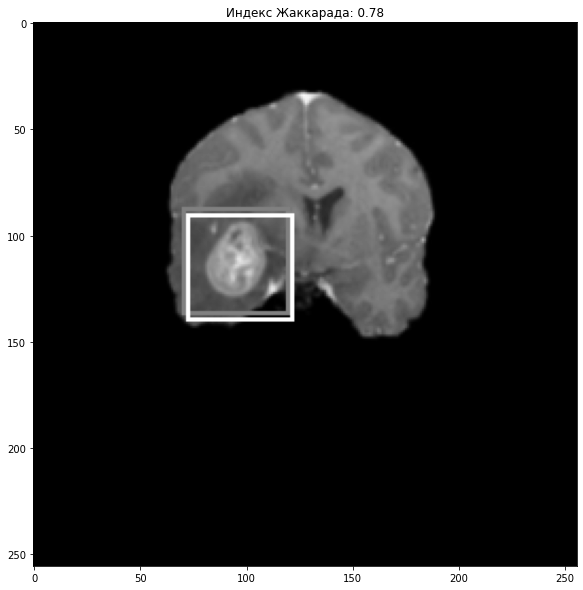

In [ ]:
path2labels_test = os.path.join(path,'test','coordinates_test.xlsx') # путь к файлу с координатами
labels_df_test = pd.read_excel(path2labels_test, index_col='ID') # сохраним значения координат bbox

img_test, label_test = load_img_label_test(labels_df_test, 1) # загрузим первое изображение
print(img_test.size, label_test) # выведем размер и координаты bbox
img_test, label_test = resize_img_label(img_test, label_test, target_size=(256,256)) # изменим размер изображения
print(img_test.size, label_test) # выведем размер и координаты bbox

img_test= TF.to_tensor(img_test) # переведем изображение в тензор
label_test = scale_label(label_test, (256,256)) # изменим масштаб bbox
print(img_test.shape) # выведем форму
with torch.no_grad(): # без подсчета градиента
    label_pred = model(img_test.unsqueeze(0).to(device))[0].cpu() # предсказываем координаты bbox
show_tensor_2labels(img_test,label_test, label_pred) # рисуем истинный и предсказанный bbox
label_bb = cxcy2bbox(torch.tensor(label_test).unsqueeze(0)) # переводим истинный bbox в тензор и добавляем 0 ось
label_pred_bb = cxcy2bbox(label_pred.unsqueeze(0)) # переводим предсказанный bbox в тензор и добавляем 0 ось
iou = torchvision.ops.box_iou(label_bb,label_pred_bb) # считаем индекс Жаккарда
plt.title('Индекс Жаккарада: %.2f' % iou.item()) # выведем коэффициент пересечения
plt.show() # выведем изображение